# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize as nlz
from numpy import apply_along_axis as apl
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Пучкин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        
    def sigmoid(self, z):
        return 1/(1+np.exp((-1)*z))
    
    def grad(self, x, beta, y):
        res = self.C * np.sign(beta)
        for i in xrange(len(res)):
            res[i] += np.sum([y[j]*x[j][i]*self.sigmoid(y[j]*x[j].dot(beta))-1 for j in xrange(len(y))])
        return res
    
    
    def fit(self, X, y):
        '''
        Обучение модели
        '''
        x_norm = nlz(np.hstack((np.ones(X.shape[0], dtype='int').reshape(X.shape[0], 1), X)))
        self.beta = nlz(np.random.random(x_norm.shape[1])-0.5)[0]
        self.new_beta = nlz(np.random.random(x_norm.shape[1])-0.5)[0]
        y1 = y.copy()
        y1[y==0] = -1
        for n_epoch in xrange(self.max_epoch):
            for i in np.random.choice(X.shape[0], X.shape[0], replace=False):
                self.beta = self.new_beta.copy()
                self.new_beta = nlz(self.beta - self.alpha / float(n_epoch+1) * self.grad(x_norm[i], self.beta, y1[i]))[0]
            self.y_hat = np.zeros(x_norm.shape[0], dtype='int')
            self.y_hat[(x_norm.dot(self.new_beta)) > 0] = 1
            
        return self
    
    def fit_mistakes(self, X, y):
        '''
        Обучение модели
        '''
        x_norm = nlz(np.hstack((np.ones(X.shape[0], dtype='int').reshape(X.shape[0], 1), X)))
        self.beta = nlz(np.random.random(x_norm.shape[1])-0.5)[0]
        self.new_beta = nlz(np.random.random(x_norm.shape[1])-0.5)[0]
        y1 = y.copy()
        y1[y==0] = -1
        for n_epoch in xrange(self.max_epoch):
            # for i in np.random.choice(X.shape[0], X.shape[0], replace=False):
            #    self.beta = self.new_beta.copy()
            #    self.new_beta = nlz(self.new_beta - self.alpha / float(n_epoch+1) * self.grad(x_norm[i], self.beta, y1[i]))[0]
            self.beta = self.new_beta.copy()
            self.new_beta = nlz(self.beta - self.alpha / float(n_epoch+1) * self.grad(x_norm, self.beta, y1))[0]
            self.y_hat_proba = np.array([self.sigmoid(i.dot(self.new_beta)) for i in x_norm])
            self.y_hat = np.zeros(x_norm.shape[0], dtype='int')
            self.y_hat[self.y_hat_proba > 0.5] = 1
            prec = np.sum(self.y_hat==y)/float(len(y))            
            print prec
            
        #for i in xrange(len(y)):
        #    print self.y_hat_proba[i], self.y_hat[i], y[i]
        
        return self
    
    def partial_fit(self, X, y):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        for n_epoch in xrange(self.max_epoch):
            for i in np.random.choice(X.shape[0], X.shape[0], replace=False):
                self.beta = self.new_beta.copy()
                self.new_beta = nlz(self.new_beta - self.alpha / (n_epoch+1) * self.grad(x_norm[i], self.beta, y[i]))[0]
            self.y_pred = np.zeros(x_norm.shape[0], dtype='int')
            self.y_pred[(x_norm.dot(self.new_beta)) > 0] = 1
                
        return self
    
    def partial_fit_mistakes(self, X, y):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        for n_epoch in xrange(self.max_epoch):
            for i in np.random.choice(X.shape[0], X.shape[0], replace=False):
                self.beta = self.new_beta.copy()
                self.new_beta = nlz(self.beta - self.alpha / (n_epoch+1) * self.grad(x_norm[i], self.beta, y[i]))[0]
            self.y_pred = np.zeros(x_norm.shape[0], dtype='int')
            self.y_pred[(x_norm.dot(self.new_beta)) > 0] = 1
            print np.sum(self.y_pred==y)/float(len(y))   
        return self
        
    def predict(self):
        return self.y_hat
    
    def predict_proba(self):
        '''
        Возвращение вероятности каждого из классов
        '''

        
        return y_hat_proba

In [24]:
a = np.array([-9,1,-1])
np.sign(a)*0.95

array([-0.95,  0.95, -0.95])

In [25]:
nlz(a)

array([[-0.98787834,  0.10976426, -0.10976426]])

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

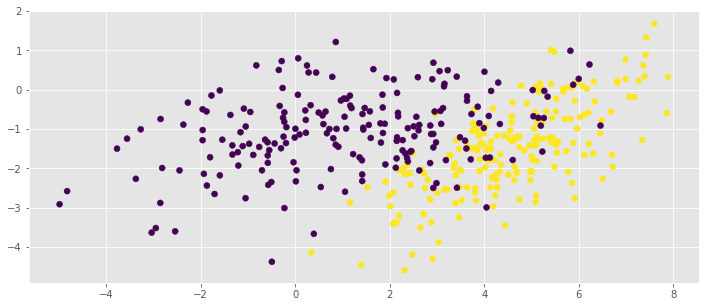

In [26]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [27]:
x = np.array([[1,1,1],[2,2,2],[3,3,3],[1,1,1]])
z = np.array([1,-1,1,-1])
(x.reshape(3,4).dot(z)) #.reshape(4,3)

array([-1,  0,  2])

In [31]:
model = MySGDClassifier(C=0.01, alpha=0.01, max_epoch=100)
model.fit_mistakes(X, y)

0.6225
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625
0.625


MySGDClassifier(C=0.01, alpha=0.01, max_epoch=100)

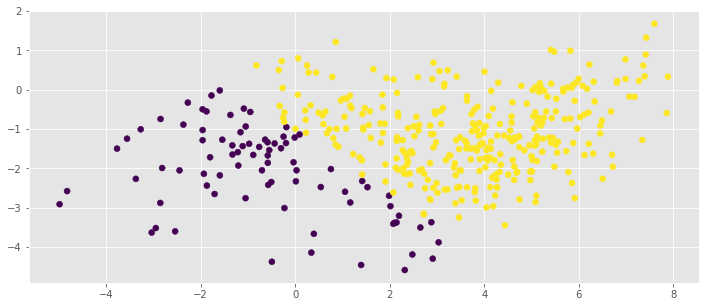

In [32]:
plt.scatter(X[:,0], X[:,1], c=model.predict())

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [ ]:
## Your Code Here

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [ ]:
## Youd Code Here

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [ ]:
## Youd Code Here